#### Installing dependencies
<code>%python main.py</code> is commented out since <code>main.py</code> has already been ran and the model is pre-trained. Model parameters saved in <code> resnet_model_parameters.pth</code>

In [ ]:
%pip install -r requirements.txt
#%python main.py 

#### Importing modules

In [45]:
import torch
import importlib
import numpy as np
import time

import utils.model_analyzer
import utils.dataloader
import models.ResNet
import models.BasicBlock
import models.compression_pipeline


importlib.reload(utils.model_analyzer)
importlib.reload(utils.dataloader)
importlib.reload(models.ResNet)
importlib.reload(models.BasicBlock)
importlib.reload(models.compression_pipeline)

from utils.model_analyzer import ModelAnalyzer
from models.compression_pipeline import ModelCompressor
from utils.dataloader import MNISTDataLoader
from models.ResNet import ResNet
from models.BasicBlock import BasicBlock

#### Load model + evaluation

In [46]:
model = ResNet(block = BasicBlock, num_blocks=[2,2,2,2])
checkpoint = torch.load("saved_models/resnet_model_parameters.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [6]:
ModelAnalyzer.get_model_summary(model)

{'Total Parameters': 11172810, 'Total Layers': 62, 'Model Size (MB)': 42.62}

In [47]:
loader = MNISTDataLoader('.\data')
test_loader = loader.get_test_loader()

In [43]:
accuracy, total = ModelAnalyzer.test_model(model=model, test_loader=test_loader)
print(f'Model accuracy = {accuracy}% on test sample size n={total}')

Model accuracy = 98.4% on test sample size n=10000


To put this in context, the total model size is over 2 orders of magnitude greater than the STM32F SRAM. Accuracy is well below SOTA since the model has only been trained for 1 epoch without optimizer customization.

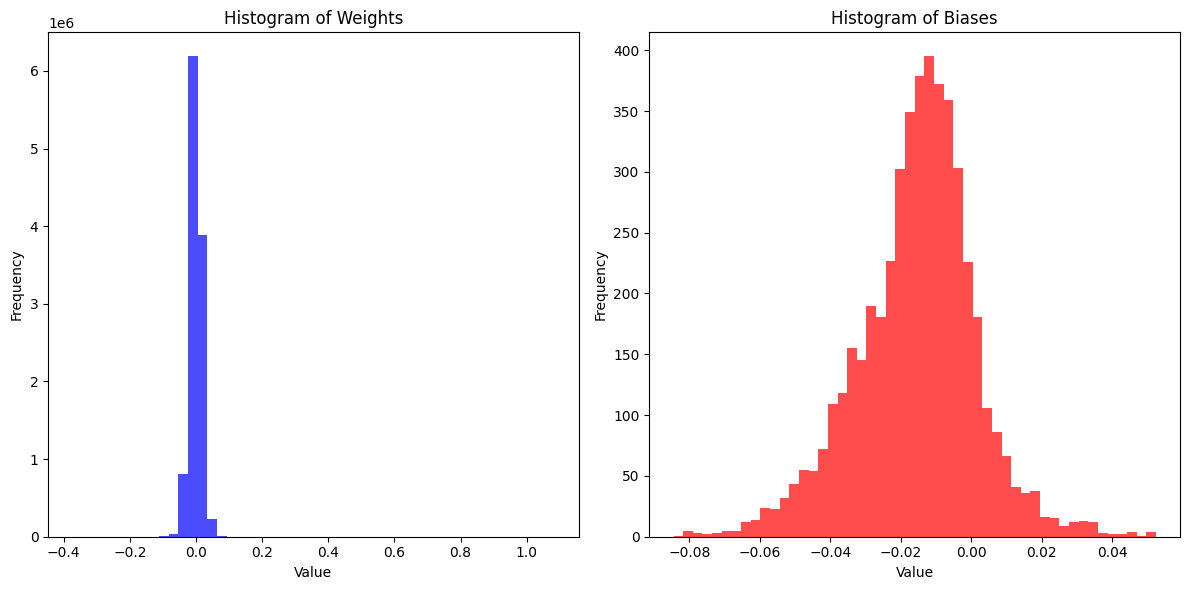

In [6]:
ModelAnalyzer.plot_data_type_distribution(model)

#### Model Compression (L1 Pruning) Evaluation

In [48]:
import time

compressor = ModelCompressor(model, test_loader=test_loader)
pruning_ratios = np.arange(0.1,1, 0.1)

In [8]:
print("PRUNING COMPARISON \n -------------------")
for ratio in pruning_ratios:
    ratio = round(ratio, 2)
    print(f"Pruning model with pruning ratio {ratio}")
    t0 = time.time()
    compressor.prune_model(ratio)
    t1 = time.time()
    print(f"Pruning complete in {round(t1 - t0, 2)} seconds")

    path = f"saved_models/resnet_model_pruned_{ratio}.pth"
    pruned_model = ResNet(block = BasicBlock, num_blocks=[2,2,2,2])
    new_state_dict = torch.load(path)
    pruned_model.load_state_dict(new_state_dict)

    acc, _ = ModelAnalyzer.test_model(pruned_model, test_loader)
    print(f'Accuracy = {acc}%')
    print("---------------------")

PRUNING COMPARISON 
 -------------------
Pruning model with pruning ratio 0.1
Pruning complete in 1.07 seconds
Accuracy = 98.41%
---------------------
Pruning model with pruning ratio 0.2
Pruning complete in 1.41 seconds
Accuracy = 98.37%
---------------------
Pruning model with pruning ratio 0.3
Pruning complete in 2.04 seconds
Accuracy = 98.43%
---------------------
Pruning model with pruning ratio 0.4
Pruning complete in 1.9 seconds
Accuracy = 98.41%
---------------------
Pruning model with pruning ratio 0.5
Pruning complete in 3.07 seconds
Accuracy = 98.36%
---------------------
Pruning model with pruning ratio 0.6
Pruning complete in 3.15 seconds
Accuracy = 97.87%
---------------------
Pruning model with pruning ratio 0.7
Pruning complete in 3.49 seconds
Accuracy = 91.9%
---------------------
Pruning model with pruning ratio 0.8
Pruning complete in 3.68 seconds
Accuracy = 50.82%
---------------------
Pruning model with pruning ratio 0.9
Pruning complete in 3.61 seconds
Accuracy = 

Pruning results make intuitive sense. Distribution of weights and biases is quite narrow (i.e. small standard deviation). More aggressive pruning cuts closer to the expectation of the distributions, thereby removing many of the important weights and degrading the accuracy significantly.

#### Model Pruning Metric Comparison

In [32]:
accuracies = []
methods = ['L1', 'L2', 'random']

for method in methods:
    print(f"Pruning with {method}")
    accuracy = []
    for ratio in pruning_ratios:
        ratio = round(ratio, 2)
        print(f"Pruning model with pruning ratio {ratio}")
        t0 = time.time()
        compressor.prune_model(ratio, pruning_type=method)
        t1 = time.time()
        print(f"Pruning complete in {round(t1 - t0, 2)} seconds")

        path = f"saved_models/resnet_model_pruned_{method}_{ratio}.pth"
        pruned_model = ResNet(block = BasicBlock, num_blocks=[2,2,2,2])
        new_state_dict = torch.load(path)
        pruned_model.load_state_dict(new_state_dict)

        acc, _ = ModelAnalyzer.test_model(pruned_model, test_loader)
        print(f'Accuracy = {acc}%')
        print("---------------------")
        accuracy.append(acc)
    print(f"Ended evaluation of {method}")
    accuracies.append(accuracy)

Pruning with L1
Pruning model with pruning ratio 0.1
Pruning complete in 1.01 seconds
Accuracy = 98.41%
---------------------
Pruning model with pruning ratio 0.2
Pruning complete in 1.21 seconds
Accuracy = 98.37%
---------------------
Pruning model with pruning ratio 0.3
Pruning complete in 1.5 seconds
Accuracy = 98.43%
---------------------
Pruning model with pruning ratio 0.4
Pruning complete in 1.71 seconds
Accuracy = 98.41%
---------------------
Pruning model with pruning ratio 0.5
Pruning complete in 2.29 seconds
Accuracy = 98.36%
---------------------
Pruning model with pruning ratio 0.6
Pruning complete in 2.5 seconds
Accuracy = 97.87%
---------------------
Pruning model with pruning ratio 0.7
Pruning complete in 2.73 seconds
Accuracy = 91.9%
---------------------
Pruning model with pruning ratio 0.8
Pruning complete in 3.55 seconds
Accuracy = 50.82%
---------------------
Pruning model with pruning ratio 0.9
Pruning complete in 3.93 seconds
Accuracy = 11.71%
-------------------

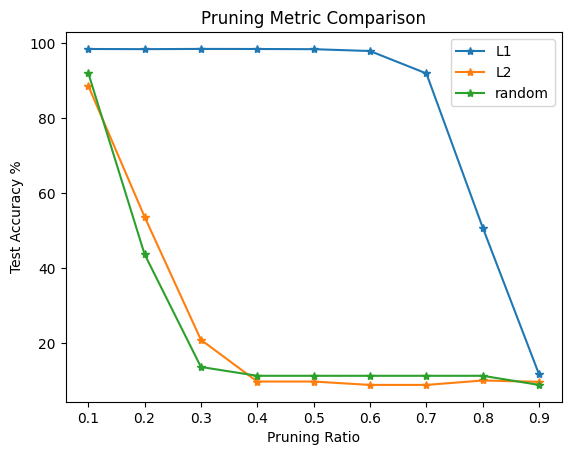

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for metric in accuracies:
    plt.plot(metric, "-*")

plt.legend(methods)
plt.ylabel("Test Accuracy %")
plt.xlabel("Pruning Ratio")
plt.xticks(range(9), [f'{i * 0.1 + 0.1:.1f}' for i in range(9)]);
plt.title("Pruning Metric Comparison");

#### Model Quantization

8-bit integer and 16-bit floating ploint quantization is explored for modules with dynamic weight-only quantization as this is the most common data types supported by resource-restricted hardware. Further, for other data types (i.e. qint16), PyTorch offers per-tensor quantization which is explored later.

In [50]:
model_int8 = compressor.quantize_model_dynamic(torch.qint8, {torch.nn.Linear,torch.nn.Conv2d,BasicBlock})
model_float16 = compressor.quantize_model_dynamic(torch.float16, {torch.nn.Linear,torch.nn.Conv2d,BasicBlock})

In [51]:
acc_int8, _ = ModelAnalyzer.test_model(model_int8, test_loader)
acc_float16, _ = ModelAnalyzer.test_model(model_float16, test_loader)

In [52]:
print(f"Test accuracy for 8-bit integer quantized model is {acc_int8}%")
print(f"Test accuracy for 16-bit float quantized model is {acc_float16}%")
print(f"Baseline accuracy is {accuracy}%")

Test accuracy for 8-bit integer quantized model is 98.39%
Test accuracy for 16-bit float quantized model is 98.4%
Baseline accuracy is 98.4%


#### Per-Tensor Quantization

More quantization types are supported for each tensor individually. Below is an exploration of the data type and number of layers quantization. Generally, per-tensor quantization is recommended for networks with large weights (i.e. Linear and RNN variants).